# Imports, styles, etc

In [1]:
import numpy as np
import pandas as pd
from liwc import Liwc
from matplotlib import pyplot as plt
import seaborn as sns
import json
from tqdm import tqdm
import scipy

import scipy.stats as stats

import sys
sys.path.append('../utils/')
from data import *
from liwc import *
from analisys import *

In [2]:
pd.set_option('display.max_colwidth', 100)

In [3]:
plt.rcParams['axes.labelsize']  = 10 # fontes no tamanho usado no template
plt.rcParams['axes.titlesize']  = 10
plt.rcParams['legend.fontsize'] = 10
plt.rcParams['xtick.labelsize'] = 10
plt.rcParams['ytick.labelsize'] = 10
plt.rcParams['font.family'] = 'serif'
# plt.rcParams['text.usetex'] = True
plt.rcParams['lines.linewidth'] = 2

In [4]:
plt.style.use('tableau-colorblind10') # use um estilo colorblind!
plt.ion()

---

# Reading and processing data

In [5]:
def liwc_sentence_parse(s,liwc):
    return liwc.parse(s.split(' '))

def get_key_counts(counter,key):
    if key in counter:
        return counter[key]
    else:
        return 0

LIWC_FILEPATH = '../data/LIWC2015_English_Flat.dic'
liwc = Liwc(LIWC_FILEPATH)

df = get_movies_dataset()
df['liwc_count'] = df['text_clean'].apply(liwc_sentence_parse, args=(liwc,))
df['bad_words_count'] = df['tags_count'].apply(get_key_counts,args=(' __ ',))
df = df[df.bad_words_count==0]
df = df.drop(columns = ['tags_count','bad_words_count'])

In [6]:
scores = pd.DataFrame()
for file in os.listdir('../data/03_scored/without_inputation/normal_toxicity/'):
    tmp = pd.read_csv('../data/03_scored/without_inputation/normal_toxicity/'+file)
    tmp['id']=file
    scores = scores.append(tmp, ignore_index=True)
scores['len'] = scores.text.str.split(' ').str.len()

total_score = (scores.groupby('id')['score'].sum()/scores.groupby('id')['len'].sum()).sort_values()[::-1]

In [7]:
df = df.set_index('id')
df['score'] = total_score
df = df.reset_index()
df = df[df.score.notna()]

In [8]:
d = get_movies_dataset()
d['bad_words_count'] = d['tags_count'].apply(get_key_counts,args=(' __ ',))

In [9]:
#subtitles without any imputation
d[d.bad_words_count==0].groupby('group').count()

,movie,age,has-en-sub,url,id,text,text_clean,tags_count,bad_words_count
group,,,,,,,,,
Black Man,82,82,82,82,82,82,82,82,82
Black Woman,42,42,42,42,42,42,42,42,42
White Man,267,267,267,267,267,267,267,267,267
White Woman,162,162,162,162,162,162,162,162,162


---

# Processing data with LIWC

In [10]:
#LIWC data

LIWC_FILEPATH = '../data/LIWC2015_English_Flat.dic'
liwc = Liwc(LIWC_FILEPATH)

liwc_df = pd.DataFrame().from_records(df['liwc_count'],index=df['id'])
liwc_df = liwc_df.fillna(0)

#normalizing 
#Normalizando pelo numero de categorias obtidas ????????????????? qual a melhor forma de fazer isso? talvez pelo numero de palavras
liwc_df_norm = (liwc_df[liwc.categories.values()].T * ( 1 / liwc_df[liwc.categories.values()].sum(axis=1) )).T

liwc_df_norm.reset_index(inplace=True)
liwc_df_norm['group'] = df['group']
liwc_df_norm['age'] = df['age']

In [26]:
df

,id,movie,age,group,has-en-sub,url,text,text_clean,liwc_count,score
0,A_yiL6YB7LE,Black Panther,2018,White Man,0,https://www.youtube.com/watch?v=A_yiL6YB7LE&ab_channel=JeremyJahns,I saw black panther and if I looked stoned out of my mind just because I'm dead as tired three h...,I saw black panther and if I looked stoned out of my mind just because I'm dead as tired three h...,"{'verb': 276, 'percept': 73, 'see': 55, 'focuspast': 50, 'function': 870, 'conj': 134, 'cogproc'...",0.011678
1,BQtPELpog1o,Black Panther,2018,White Man,0,https://www.youtube.com/watch?v=BQtPELpog1o&ab_channel=TheFlickPick,[Music] either guys how are you so let's talk about Black Panther and I have a lot to say about ...,either guys how are you so let's talk about Black Panther and I have a lot to say about it but ...,"{'adj': 92, 'compare': 63, 'quant': 47, 'cogproc': 260, 'differ': 65, 'social': 214, 'friend': 1...",0.011675
2,Wc0pK98d65Q,Black Panther,2018,Black Man,0,https://www.youtube.com/watch?v=Wc0pK98d65Q&ab_channel=TheAmazingLucas,this movie started up so well and crashed and burned right in front of my face oh goodness so fi...,this movie started up so well and crashed and burned right in front of my face oh goodness so fi...,"{'function': 1795, 'pronoun': 584, 'ipron': 255, 'leisure': 31, 'verb': 545, 'focuspast': 83, 'r...",0.017882
3,id882pdRz40,Black Panther,2018,Black Man,0,https://www.youtube.com/watch?v=id882pdRz40&ab_channel=ShawnCee,so we've had enough time to soak in the movie black panther came out I believe February 16th of ...,so we've had enough time to soak in the movie black panther came out I believe February 16th of ...,"{'function': 2039, 'adverb': 238, 'conj': 214, 'pronoun': 559, 'ppron': 263, 'we': 37, 'auxverb'...",0.014859
4,h_Qo0arHl5Q,Black Panther,2018,White Woman,0,https://www.youtube.com/watch?v=h_Qo0arHl5Q&ab_channel=BeyondTheTrailer,so at Disney press screenings they take your phone they don't trust us every other studio lets y...,so at Disney press screenings they take your phone they don't trust us every other studio lets y...,"{'function': 1142, 'adverb': 149, 'conj': 177, 'prep': 251, 'relativ': 249, 'space': 127, 'perce...",0.009667
...,...,...,...,...,...,...,...,...,...,...
548,D-Ue15pL_Lk,Logan,2017,White Woman,0,https://www.youtube.com/watch?v=D-Ue15pL_Lk&ab_channel=WrappedUpInFilm,hey guys this is a wrapped up in film I'm Zoe so I've just got back from watching Logan at the c...,hey guys this is a wrapped up in film I'm Zoe so I've just got back from watching Logan at the c...,"{'social': 66, 'informal': 20, 'friend': 6, 'male': 19, 'function': 305, 'pronoun': 94, 'ipron':...",0.014365
549,csbRjP3GyhQ,Logan,2017,White Woman,0,https://www.youtube.com/watch?v=csbRjP3GyhQ&ab_channel=RazzReviews,[Music] hi and welcome to residues today i'm going to be reviewing Logan Logan is the tenth inst...,hi and welcome to residues today i'm going to be reviewing Logan Logan is the tenth installment...,"{'social': 148, 'drives': 81, 'affiliation': 27, 'function': 943, 'conj': 149, 'affect': 107, 'p...",0.010778
550,LZqhBeEdGZk,Logan,2017,Black Man,0,https://www.youtube.com/watch?v=LZqhBeEdGZk&ab_channel=BlackCriticGuy,one last time [Music] hey guys the last critic guy into Dana March third is a very very monument...,one last time hey guys the last critic guy into Dana March third is a very very monumental day ...,"{'number': 28, 'relativ': 253, 'time': 105, 'social': 179, 'informal': 21, 'friend': 14, 'male':...",0.011799
551,gJDctCOOhsQ,Logan,2017,Black Man,0,https://www.youtube.com/watch?v=gJDctCOOhsQ&ab_channel=CaibaShow,watch it bub welcome to the Kaiba she oh yes finally after 17 long years you guys finally delive...,watch it bub welcome to the Kaiba she oh yes finally after 17 long years you guys finally delive...,"{'percept': 13, 'see': 9, 'focuspresent': 46, 'function': 220, 'pronoun': 62, 'ipron': 38, 'affe...",0.016163


In [11]:
#calculating mean rank for each liwc category in order to apply kruskall-wallis test

liwc_df_rank = liwc_df_norm.copy()
for col in liwc.categories.values():
    liwc_df_rank[col] = liwc_df_rank[col].rank()

---

## Kruscal-Wallis Test

In [12]:
experiments = []
old_experiments = []

for feature in liwc.categories.values():
    
    result = stats.kruskal(
        liwc_df_rank[liwc_df_rank.group=='White Man'][feature],
        liwc_df_rank[liwc_df_rank.group=='White Woman'][feature],
        liwc_df_rank[liwc_df_rank.group=='Black Man'][feature],
        liwc_df_rank[liwc_df_rank.group=='Black Woman'][feature],
    )
    experiments.append({
        'feature': feature,
        'statistic': result[0],
        'pvalue': result[1]
    })
experiments = pd.DataFrame(experiments)

---
## Word counts

In [7]:
groups_counts_df = pd.read_csv('../data/categories_groups_counts_df.csv')

group_word_counts = groups_counts_df.groupby('group').sum()['count'].to_dict()

In [14]:
groups_counts_df = groups_counts_df.dropna()
groups_counts_df['word'] = groups_counts_df['word'].str.replace('\n','')
groups_counts_df['word'] = groups_counts_df['word'].str.replace("[^a-zA-Z]+",'')


groups_counts_df = groups_counts_df.drop(index=groups_counts_df[groups_counts_df['word'].str.replace(' ','').str.len()==0].index)
groups_counts_df['word'] = groups_counts_df['word'].str.lower()
groups_counts_df = groups_counts_df.sort_values(['word','group','categories'])


In [15]:
count_column = groups_counts_df.groupby(['group','word'],as_index=False).sum().set_index(['group','word'])['count']
groups_counts_df = groups_counts_df.drop_duplicates(['group','word'],keep='first').set_index(['group','word'])
groups_counts_df['count'] = count_column
groups_counts_df = groups_counts_df.reset_index()

In [16]:
groups_counts_df['freq']=groups_counts_df.apply( lambda x: x['count']/group_word_counts[x['group']],axis=1)

## bad_words

In [17]:
data = json.load(open('../data/bad_words_scored.json'))
word_scores = pd.DataFrame({'words':data.keys(),'score': data.values()})

---
Bad Word Counts

In [18]:
# bad_words_counts_df = pd.DataFrame(columns=['count','group','bad_word']).set_index(['group','bad_word'])

# for group in df.group.unique():
#     for sent in tqdm(df[df.group==group]['text_clean'].str.split(' ')):
#         for word in sent:
#             if (word ==word_scores.words).any():
#                 if (group,word) not in bad_words_counts_df.index:
#                     bad_words_counts_df.loc[(group,word),'count'] = 1
#                 else:
#                     bad_words_counts_df.loc[(group,word),'count'] += 1
# bad_words_counts_df = bad_words_counts_df.reset_index()

# for group in df.group.unique():
#     bad_words_counts_df.loc[bad_words_counts_df.group==group,'freq'] = (
#         bad_words_counts_df[bad_words_counts_df.group==group]['count']
#         /
#         groups_counts_df[groups_counts_df.group==group]['count'].sum()
#     )
    
# bad_words_counts_df = bad_words_counts_df.merge(word_scores, left_on='bad_word',right_on='words')[['group','bad_word','count','freq','score']]

In [19]:
bad_words_counts_df = pd.read_csv('../data/bad_words_counts_df.csv')

---

# Informal

In [22]:
groups_counts_df[groups_counts_df.categories.str.contains('informal')]

,group,word,categories,count,freq
95,Black Man,absolutely,"['function', 'adverb', 'cogproc', 'certain', 'informal', 'assent']",25,0.000187
96,Black Woman,absolutely,"['function', 'adverb', 'cogproc', 'certain', 'informal', 'assent']",27,0.000319
97,White Man,absolutely,"['function', 'adverb', 'cogproc', 'certain', 'informal', 'assent']",174,0.000474
98,White Woman,absolutely,"['function', 'adverb', 'cogproc', 'certain', 'informal', 'assent']",129,0.000537
801,Black Man,agree,"['affect', 'posemo', 'informal', 'assent']",9,0.000067
...,...,...,...,...,...
40910,White Woman,yes,"['informal', 'assent']",97,0.000404
40923,Black Man,yo,"['informal', 'netspeak']",31,0.000231
40924,Black Woman,yo,"['informal', 'netspeak']",5,0.000059
40925,White Man,yo,"['informal', 'netspeak']",3,0.000008


---

# uma tabela com media, rank e p-valor das variaveis analisadas

In [17]:
tmp_variables = ['informal','assent','filler','swear','netspeak']
tmp = liwc_df_rank.groupby('group').median()[tmp_variables].rename(columns=dict(zip(tmp_variables,[x+'_median' for x in tmp_variables])))
tmp

,informal_median,assent_median,filler_median,swear_median,netspeak_median
group,,,,,
Black Man,382.0,303.0,205.0,346.0,355.0
Black Woman,390.5,388.0,205.0,332.0,374.0
White Man,238.5,220.5,205.0,146.0,263.5
White Woman,261.0,316.0,205.0,146.0,213.0


In [18]:
tmp = pd.DataFrame()

In [19]:
pd.concat(
    [
        liwc_df_rank.groupby('group').median()['informal'].rename('median'),
        liwc_df_rank.groupby('group').mean()['informal'].rename('median'),
    ],
    axis=1
)

,median,median
group,,
Black Man,382.0,344.160494
Black Woman,390.5,368.559524
White Man,238.5,247.206767
White Woman,261.0,267.200617


In [20]:
d = {}
for tmp_var in tmp_variables:
    d[tmp_var] = pd.concat(
        [
            liwc_df_rank.groupby('group').median()[tmp_var].rename('mean-rank median'),
            liwc_df_norm.groupby('group').mean()[tmp_var].rename('mean'),
            pd.Series(
                [experiments[experiments.feature==tmp_var]['pvalue'].iloc[0] for _ in range(4)],
                index=['Black Man', 'Black Woman', 'White Man', 'White Woman']
            ).rename('p-value'),
        ],
        axis=1
    )
tmp = pd.concat(d,axis=1)
tmp

informal                                   assent  \
            mean-rank median      mean       p-value mean-rank median   
group                                                                   
Black Man              382.0  0.004713  2.746028e-08            303.0   
Black Woman            390.5  0.005030  2.746028e-08            388.0   
White Man              238.5  0.003368  2.746028e-08            220.5   
White Woman            261.0  0.003668  2.746028e-08            316.0   

                                              filler                     \
                 mean       p-value mean-rank median      mean  p-value   
group                                                                     
Black Man    0.001308  6.372621e-07            205.0  0.000115  0.00106   
Black Woman  0.001650  6.372621e-07            205.0  0.000139  0.00106   
White Man    0.000902  6.372621e-07            205.0  0.000067  0.00106   
White Woman  0.001159  6.372621e-07            205.0  0.000133  0.00106   

                       swear                             netspeak            \
            mean-rank median      mean   p-value mean-rank median      mean   
group                                                                         
Black Man              346.0  0.000406  0.002309            355.0  0.001331   
Black Woman            332.0  0.000327  0.002309            374.0  0.001197   
White Man              146.0  0.000233  0.002309            263.5  0.000782   
White Woman            146.0  0.000270  0.002309            213.0  0.000680   

                           
                  p-value  
group                      
Black Man    4.152565e-07  
Black Woman  4.152565e-07  
White Man    4.152565e-07  
White Woman  4.152565e-07

--- 
# Black

In [421]:
#o quanto cada grupo fala a palavra Black
bad_words_counts_df[bad_words_counts_df.bad_word=='black'][['group','freq']]

,group,freq
0,White Man,0.000327
1,Black Man,0.000836
2,White Woman,0.000383
3,Black Woman,0.001618


In [422]:
bad_words_counts_df[bad_words_counts_df.bad_word=='black']

,group,bad_word,count,freq,score,normalized_score
0,White Man,black,120,0.000327,0.34882,0.000114
1,Black Man,black,112,0.000836,0.34882,0.000292
2,White Woman,black,92,0.000383,0.34882,0.000134
3,Black Woman,black,137,0.001618,0.34882,0.000564


In [436]:
black_scores = scores[scores.text.str.contains('black|Black')]
# control_scores = scores[ ~ scores.text.str.contains('black|Black')].sample(len(black_scores))
random_control_scores = scores.sample(len(black_scores))

In [553]:
scores_merged = scores.merge(df[['id','group']])
control_scores = pd.concat([
    scores_merged[ ~ scores_merged.text.str.contains('black|Black') & (scores_merged.group=='Black Man')].sample(int(len(black_scores)/4)),
    scores_merged[ ~ scores_merged.text.str.contains('black|Black') & (scores_merged.group=='Black Woman')].sample(int(len(black_scores)/4)),
    scores_merged[ ~ scores_merged.text.str.contains('black|Black') & (scores_merged.group=='White Man')].sample(int(len(black_scores)/4)),
    scores_merged[ ~ scores_merged.text.str.contains('black|Black') & (scores_merged.group=='White Woman')].sample(int(len(black_scores)/4))
])

In [554]:
exemples=[131,189,409]
tmp = black_scores.sort_values('score',ascending=False).merge(df[['id','group']])
# tmp[tmp.group.str.contains('White') & tmp.text.str.contains('supremacist')  ].sort_values('score',ascending=False).head(20)
tmp.loc[exemples]

,text,score,id,len,group
131,his friend in the movie is black and gay I mean like technically they are,0.783367,S9EalkmwVuY,15,Black Woman
189,hi I'm Andre and I'm a black nerd and this is a first impressions review,0.604881,ofVFJFL2lIA,15,Black Man
409,Klansmen is that while it juxtaposes very effectively white and black power extremist groups at,0.191562,WxLmGBm3R84,15,White Woman


In [555]:
exemples=[22930]

In [556]:
tmp = scores.sort_values('score',ascending=False).merge(df[['id','group']])
tmp[tmp.group.str.contains('White') & tmp.text.str.contains('supremacist')  ].sort_values('score',ascending=False).head(20)

,text,score,id,len,group
26479,showing you how dangerous and just purely awful these white supremacists are how they're motivated,0.743257,k5jO1sRGyXU,15,White Man
26480,white supremacist group known as a Ku Klux Klan Ron calls the white supremacist and,0.625372,k5jO1sRGyXU,15,White Man
26485,pretends to be a white supremacist himself and named Ron Stallworth and Flip actually attends,0.446250,k5jO1sRGyXU,15,White Man
22930,"Wallace, the white supremacist governor of Alabama, also privately struggle with their own doubt...",0.319992,tk4dIgIG5Qs,15,White Man


In [562]:
def get_black_stats(tmp_scores, df, scores):

    tmp_scores = tmp_scores.merge(df[['id', 'group']])
    tmp_scores['black'] = tmp_scores.text.str.contains('black|Black')

    tmp = tmp_scores.merge(df[['id', 'group']]).groupby('group').count()[['score']]
    tmp.columns = ['count']
    tmp['freq'] = tmp['count']/scores.merge(df[['id', 'group']]).groupby('group').count()['score']
    tmp['mean_score'] = tmp_scores.groupby('group').mean()['score']
    tmp['median_score'] = tmp_scores.groupby('group').median()['score']
    tmp['black_ocurences'] = tmp_scores.groupby('group').sum()['black']
    return tmp

In [563]:
#BLACK SCORES
# sentenças tem a palavra BLACK em cada grupo
get_black_stats(black_scores, df, scores)

,count,freq,mean_score,median_score,black_ocurences
group,,,,,
Black Man,139,0.015651,0.411843,0.403209,139
Black Woman,139,0.024702,0.417817,0.403346,139
White Man,178,0.007311,0.236100,0.228153,178
White Woman,111,0.006952,0.268333,0.241587,111


In [564]:
#CONTROL SCORES
# sentenças tem a palavra BLACK em cada grupo
get_black_stats(control_scores,df,scores)

,count,freq,mean_score,median_score,black_ocurences
group,,,,,
Black Man,141,0.015877,0.177532,0.116455,0
Black Woman,141,0.025058,0.182901,0.126606,0
White Man,141,0.005791,0.127159,0.094581,0
White Woman,141,0.008831,0.143410,0.111181,0


In [560]:
#RANDON CONTROL SCORES
# sentenças tem a palavra BLACK em cada grupo
get_black_stats(random_control_scores,df,scores)

,count,freq,mean_score,black_ocurences
group,,,,
Black Man,97,0.010922,0.173559,0
Black Woman,70,0.012440,0.156956,2
White Man,245,0.010062,0.149252,0
White Woman,155,0.009708,0.144361,1


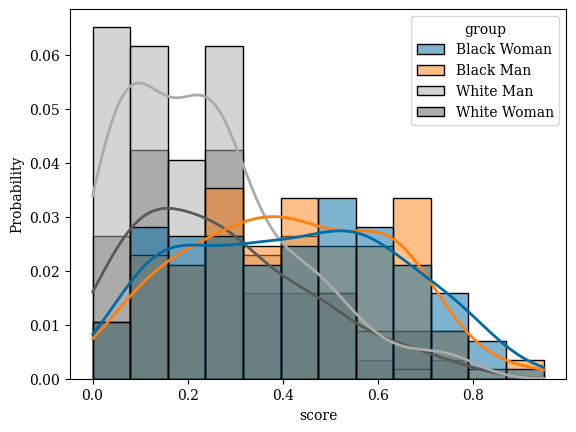

In [475]:
tmp = black_scores.sort_values('score',ascending=False).merge(df[['id','group']])
sns.histplot(tmp,x='score',hue='group',kde=True,stat='probability')
plt.show()

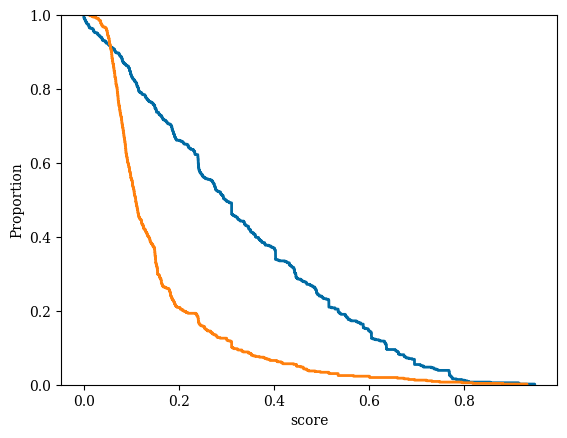

In [569]:
g1 = sns.ecdfplot(tmp_black,x='score',complementary=True)
g2 = sns.ecdfplot(tmp_control,x='score',complementary=True,ax=g1)
plt.show()

<AxesSubplot:xlabel='score', ylabel='Proportion'>

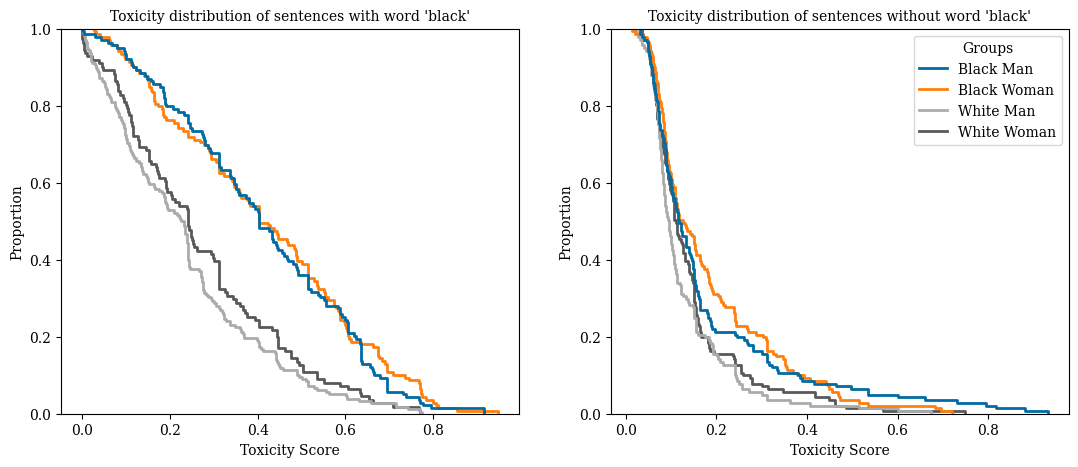

In [561]:
tmp_black = black_scores.sort_values('score',ascending=False).merge(df[['id','group']])
tmp_control = control_scores.sort_values('score',ascending=False).merge(df[['id','group']])
fig, axs = plt.subplots(ncols=2)
fig.set_size_inches((13,5))

g1 = sns.ecdfplot(tmp_black,x='score',hue='group',complementary=True,ax=axs[0], hue_order = ['Black Man', 'Black Woman', 'White Man', 'White Woman'],legend=False)
g2 = sns.ecdfplot(tmp_control,x='score',hue='group',complementary=True,ax=axs[1],hue_order = ['Black Man', 'Black Woman', 'White Man', 'White Woman'])

g1.set_title("Toxicity distribution of sentences with word 'black'")
g2.set_title("Toxicity distribution of sentences without word 'black'")

g1.set_xlabel('Toxicity Score')
g2.set_xlabel('Toxicity Score')
g2.legend_.set_title('Groups')
plt.savefig('black_word_distribution_test_control.pdf')
plt.show()

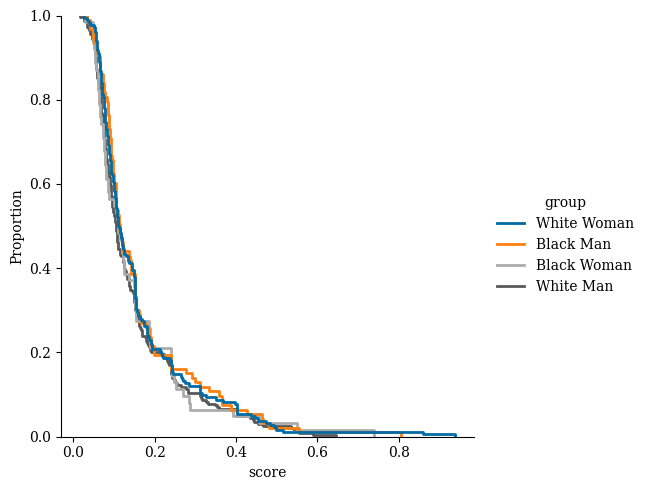

In [482]:

sns.displot(tmp,x='score',hue='group',kind='ecdf',complementary=True)
plt.show()

In [135]:
tmp_scores = black_scores
tmp_scores = tmp_scores.merge(df[['id', 'group']])
tmp_scores

,text,score,id,len,group
0,this was worth it I mean they could have just dyed their hair black as,0.445918,qAS6-MGSAao,15,White Woman
1,from orange is the new black even if it was just for one scene she,0.240206,qAS6-MGSAao,15,White Woman
2,be more kind of like a like a black comedy satire it has a lot,0.241337,U2GDM9_pGd8,15,White Woman
3,was expecting and it is yeah so it's like it's like a black comedy about,0.310894,U2GDM9_pGd8,15,White Woman
4,movie starts off amazing they tell the history of of will condign how the Black,0.293305,Wc0pK98d65Q,15,Black Man
...,...,...,...,...,...
562,gonna give black plans but a nine out of ten because I think the pros,0.240793,k5jO1sRGyXU,15,White Man
563,message this is a good choice so did you guys see black Klansmen yet what,0.368632,k5jO1sRGyXU,15,White Man
564,racism and identity but from the point of view of a black man and i,0.707186,Tmq7tS_oOEs,15,White Woman
565,goes over and does it to herself i'll awesome sort of like black dahlia thing,0.298058,Tmq7tS_oOEs,15,White Woman


In [141]:
tmp_scores[
    tmp_scores.group.str.contains('Black') 
    &  (tmp_scores.score > .2) &  (tmp_scores.score < .5)
].sample(10)

,text,score,id,len,group
110,to everyone who wore their Magical Black Girl merchandise to go watch this m...,0.255884,vLOv3FgCT6U,15,Black Woman
150,him and um what we just seen in my range black bottom uh coleman domingo,0.246826,QrIPpxf8yxM,15,Black Man
382,how to say it I've never said it out loud black pit cake click clansmen,0.279168,eXhbO3NbOxU,15,Black Man
78,let's really dive into the importance of this all-black cast and the writers...,0.289045,-7YPgSlV50o,15,Black Woman
33,of these ladies have written include so the spy who dumped me good girls bla...,0.481873,FT3zuj69QfQ,15,Black Woman
319,the dark black skin representing the moonlight they reflected off the black ...,0.360455,F-RUeqsnS4s,15,Black Woman
95,literally making black history right now like I said support black readers s...,0.469022,-7YPgSlV50o,15,Black Woman
360,so stuck at the movie so definitely check that film out and the last black,0.208227,fyQ7ro0qk_g,15,Black Man
365,watching this movie has a mixed person the black side of me was like no,0.323535,ZBdN9m6kIRE,15,Black Woman
213,scene stealer in black pants and it's funny those two met in college and acting,0.400906,K5Om-JJH4HY,15,Black Man


In [146]:
tmp_scores[
    tmp_scores.group.str.contains('Black') 
    &  (tmp_scores.score > .2) &  (tmp_scores.score < .5)
].loc[[319]]

,text,score,id,len,group
319,the dark black skin representing the moonlight they reflected off the black skin that my,0.360455,F-RUeqsnS4s,15,Black Woman


In [30]:
black_scores.score.mean()

0.33004162158361566

In [32]:
control_scores.score.mean()

0.16169038884832454

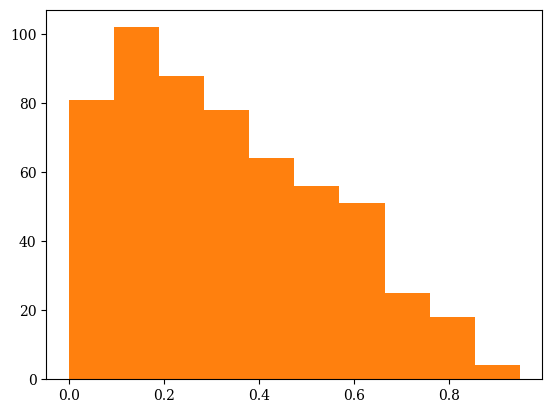

In [35]:
plt.hist(black_scores.score)
plt.show()

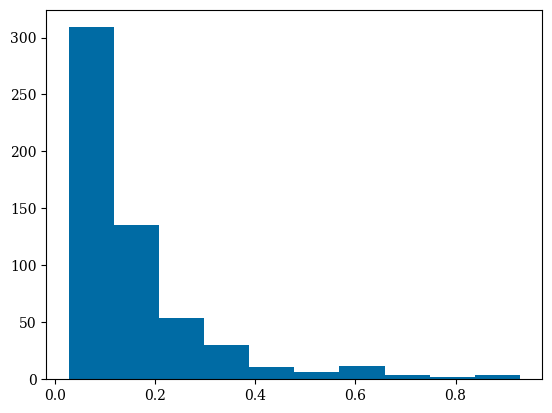

In [37]:
plt.hist(control_scores.score)
plt.show()

---


# Gonna

In [230]:
#o quanto cada grupo fala a palavra Black

bad_words_counts_df[bad_words_counts_df.bad_word=='gonna']

,group,bad_word,count,freq,score,normalized_score


In [57]:
bad_words_counts_df[bad_words_counts_df.bad_word=='gonaa']

,score
group,
Black Man,8881
Black Woman,5627
White Man,24348
White Woman,15967


In [82]:
black_scores = scores[scores.text.str.contains('gonna')]
control_scores = scores[ ~ scores.text.str.contains('gonna')].sample(len(black_scores))
random_control_scores = scores.sample(len(black_scores))

In [118]:
def get_black_stats(tmp_scores, df, scores):

    tmp_scores = tmp_scores.merge(df[['id', 'group']])
    tmp_scores['black'] = tmp_scores.text.str.contains('black|Black')

    tmp = tmp_scores.merge(df[['id', 'group']]).groupby('group').count()[['score']]
    tmp.columns = ['count']
    tmp['freq'] = tmp['count']/scores.merge(df[['id', 'group']]).groupby('group').count()['score']
    tmp['mean_score'] = tmp_scores.groupby('group').mean()['score']
    tmp['black_ocurences'] = tmp_scores.groupby('group').sum()['black']
    return tmp

In [119]:
#BLACK SCORES
# sentenças tem a palavra BLACK em cada grupo
get_black_stats(black_scores, df, scores)

,count,freq,mean_score,black_ocurences
group,,,,
Black Man,139,0.015651,0.411843,139
Black Woman,139,0.024702,0.417817,139
White Man,178,0.007311,0.236100,178
White Woman,111,0.006952,0.268333,111


In [120]:
#CONTROL SCORES
# sentenças tem a palavra BLACK em cada grupo
get_black_stats(control_scores,df,scores)

,count,freq,mean_score,black_ocurences
group,,,,
Black Man,100,0.011260,0.158043,0
Black Woman,53,0.009419,0.200686,0
White Man,237,0.009734,0.141895,0
White Woman,177,0.011085,0.135966,0


In [121]:
#RANDON CONTROL SCORES
# sentenças tem a palavra BLACK em cada grupo
get_black_stats(random_control_scores,df,scores)

,count,freq,mean_score,black_ocurences
group,,,,
Black Man,96,0.010810,0.171574,2
Black Woman,61,0.010841,0.189809,0
White Man,243,0.009980,0.143413,0
White Woman,167,0.010459,0.163066,0


In [135]:
tmp_scores = black_scores
tmp_scores = tmp_scores.merge(df[['id', 'group']])
tmp_scores

,text,score,id,len,group
0,this was worth it I mean they could have just dyed their hair black as,0.445918,qAS6-MGSAao,15,White Woman
1,from orange is the new black even if it was just for one scene she,0.240206,qAS6-MGSAao,15,White Woman
2,be more kind of like a like a black comedy satire it has a lot,0.241337,U2GDM9_pGd8,15,White Woman
3,was expecting and it is yeah so it's like it's like a black comedy about,0.310894,U2GDM9_pGd8,15,White Woman
4,movie starts off amazing they tell the history of of will condign how the Black,0.293305,Wc0pK98d65Q,15,Black Man
...,...,...,...,...,...
562,gonna give black plans but a nine out of ten because I think the pros,0.240793,k5jO1sRGyXU,15,White Man
563,message this is a good choice so did you guys see black Klansmen yet what,0.368632,k5jO1sRGyXU,15,White Man
564,racism and identity but from the point of view of a black man and i,0.707186,Tmq7tS_oOEs,15,White Woman
565,goes over and does it to herself i'll awesome sort of like black dahlia thing,0.298058,Tmq7tS_oOEs,15,White Woman


In [141]:
tmp_scores[
    tmp_scores.group.str.contains('Black') 
    &  (tmp_scores.score > .2) &  (tmp_scores.score < .5)
].sample(10)

,text,score,id,len,group
110,to everyone who wore their Magical Black Girl merchandise to go watch this m...,0.255884,vLOv3FgCT6U,15,Black Woman
150,him and um what we just seen in my range black bottom uh coleman domingo,0.246826,QrIPpxf8yxM,15,Black Man
382,how to say it I've never said it out loud black pit cake click clansmen,0.279168,eXhbO3NbOxU,15,Black Man
78,let's really dive into the importance of this all-black cast and the writers...,0.289045,-7YPgSlV50o,15,Black Woman
33,of these ladies have written include so the spy who dumped me good girls bla...,0.481873,FT3zuj69QfQ,15,Black Woman
319,the dark black skin representing the moonlight they reflected off the black ...,0.360455,F-RUeqsnS4s,15,Black Woman
95,literally making black history right now like I said support black readers s...,0.469022,-7YPgSlV50o,15,Black Woman
360,so stuck at the movie so definitely check that film out and the last black,0.208227,fyQ7ro0qk_g,15,Black Man
365,watching this movie has a mixed person the black side of me was like no,0.323535,ZBdN9m6kIRE,15,Black Woman
213,scene stealer in black pants and it's funny those two met in college and acting,0.400906,K5Om-JJH4HY,15,Black Man


In [146]:
tmp_scores[
    tmp_scores.group.str.contains('Black') 
    &  (tmp_scores.score > .2) &  (tmp_scores.score < .5)
].loc[[319]]

,text,score,id,len,group
319,the dark black skin representing the moonlight they reflected off the black skin that my,0.360455,F-RUeqsnS4s,15,Black Woman


In [30]:
black_scores.score.mean()

0.33004162158361566

In [32]:
control_scores.score.mean()

0.16169038884832454

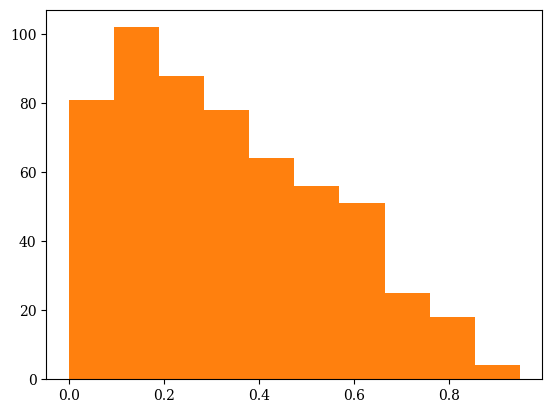

In [35]:
plt.hist(black_scores.score)
plt.show()

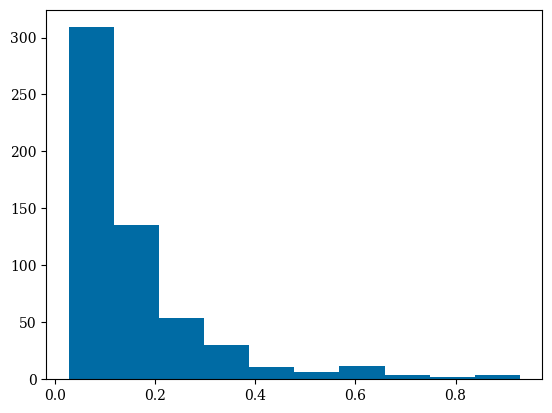

In [37]:
plt.hist(control_scores.score)
plt.show()

---

In [239]:
groups_counts_df[groups_counts_df.categories.str.contains('informal') & (groups_counts_df.group=='Black Woman')].sort_values('count', ascending=False).head(40)

,group,word,categories,count,freq
25094,Black Woman,oh,"['informal', 'nonflu']",264,0.003117
15265,Black Woman,gonna,"['verb', 'focusfuture', 'relativ', 'motion', 'informal', 'netspeak']",173,0.002043
25113,Black Woman,okay,"['affect', 'posemo', 'informal', 'assent']",157,0.001854
39858,Black Woman,well,"['function', 'adverb', 'affect', 'posemo', 'informal', 'nonflu']",154,0.001818
38138,Black Woman,um,"['informal', 'nonflu']",121,0.001429
40871,Black Woman,yeah,"['informal', 'assent']",107,0.001263
40908,Black Woman,yes,"['informal', 'assent']",46,0.000543
16746,Black Woman,hey,"['social', 'informal']",31,0.000366
7646,Black Woman,cool,"['adj', 'affect', 'posemo', 'percept', 'feel', 'informal', 'assent']",29,0.000342
38108,Black Woman,uh,"['informal', 'nonflu']",28,0.000331


In [242]:
tmp = []
tmp.append(groups_counts_df[groups_counts_df.word=="aint"].set_index('group')['freq'].rename("aint"))
tmp.append(groups_counts_df[groups_counts_df.word=="yall"].set_index('group')['freq'].rename("y'all"))
tmp.append(groups_counts_df[groups_counts_df.word=="dope"].set_index('group')['freq'].rename("dope"))
tmp.append(groups_counts_df[groups_counts_df.word=="chill"].set_index('group')['freq'].rename("chill"))
tmp.append(groups_counts_df[groups_counts_df.word=="gonna"].set_index('group')['freq'].rename("gonna"))
tmp.append(groups_counts_df[(groups_counts_df.word=="ima") | (groups_counts_df.word=="imma")].groupby('group').sum()['freq'].rename("i'ma"))

pd.concat(tmp,axis=1)*10**4

,aint,y'all,dope,chill,gonna,i'ma
Black Man,1.268931,2.985721,2.463220,0.447858,27.319345,0.298572
Black Woman,0.354250,3.778665,0.354250,0.354250,20.428406,0.590416
White Man,0.190846,0.163582,0.136319,0.027264,15.403994,0.027264
White Woman,0.249604,0.124802,0.041601,NaN,14.851423,NaN


---
# Relation between words spoken by black people and toxicity

In [309]:
groups_counts_df_scored['count_score'] = groups_counts_df_scored['count']*groups_counts_df_scored['score']

In [326]:
tmp = groups_counts_df_scored[groups_counts_df_scored.score>.2]
tmp.groupby('group').sum()['count_score']/tmp.groupby('group').sum()['count']

group
Black Man      0.496289
Black Woman    0.469863
White Man      0.492168
White Woman    0.500245
dtype: float64

In [342]:
tmp = pd.DataFrame()
for line in groups_counts_df_scored.itertuples():
    tmp = tmp.append({
        'word': line.word,
        'group': line.group,
        'count': 1,
        'score': line.score
    },ignore_index=True)
tmp

,count,group,score,word
0,1.0,White Man,0.443301,abortion
1,1.0,White Woman,0.443301,abortion
2,1.0,Black Man,0.249865,abuse
3,1.0,White Man,0.249865,abuse
4,1.0,White Woman,0.249865,abuse
...,...,...,...,...
671,1.0,White Woman,0.239634,whitey
672,1.0,White Man,0.053394,whiz
673,1.0,White Man,0.051655,willie
674,1.0,White Man,0.135043,willy


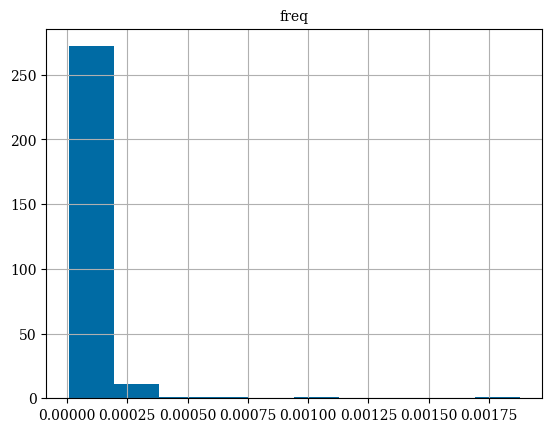

In [272]:
tmp = groups_counts_df_scored[groups_counts_df_scored.group.str.contains('Black')]
# tmp = tmp[tmp.freq<.00025]
tmp.hist('freq')
plt.show()

In [315]:
groups_counts_df_scored.groupby('group').sum()['count_score']

group
Black Man      347.472951
Black Woman    237.365361
White Man      693.579380
White Woman    443.355378
Name: count_score, dtype: float64

In [317]:
groups_counts_df_scored[groups_counts_df_scored.score>.2].groupby('group').sum()

,count,freq,score,freq_score,count_score
group,,,,,
Black Man,625,0.004665,46.109054,231.528364,310.180865
Black Woman,444,0.005243,41.604579,246.344160,208.619015
White Man,1217,0.003318,65.591388,163.300936,598.968238
White Woman,772,0.003212,52.935042,160.657038,386.188994


In [259]:
groups_counts_df_scored = groups_counts_df.merge(word_scores, left_on = 'word', right_on='words')
groups_counts_df_scored

In [283]:
groups_counts_df_scored['freq_score'] = (groups_counts_df_scored['freq']*groups_counts_df_scored['score'])*100000

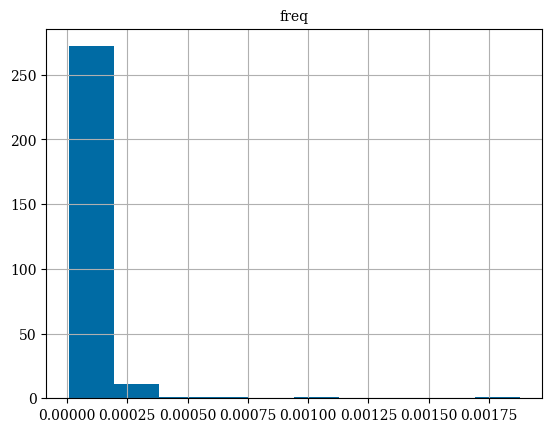

In [272]:
tmp = groups_counts_df_scored[groups_counts_df_scored.group.str.contains('Black')]
# tmp = tmp[tmp.freq<.00025]
tmp.hist('freq')
plt.show()

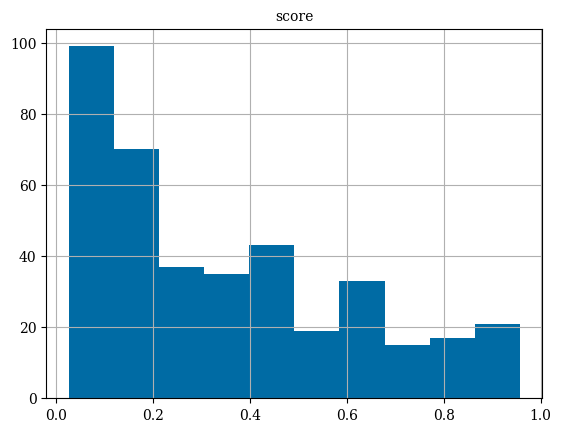

In [274]:
tmp = groups_counts_df_scored[groups_counts_df_scored.group.str.contains('White')]
# tmp = tmp[tmp.freq<.00025]
tmp.hist('score',)
plt.show()

In [353]:
tmp.groupby('group').mean()

,count,score
group,,
Black Man,1.0,0.346491
Black Woman,1.0,0.352095
White Man,1.0,0.349210
White Woman,1.0,0.346212


In [360]:
tmp

,count,group,score,word
0,1.0,White Man,0.443301,abortion
1,1.0,White Woman,0.443301,abortion
2,1.0,Black Man,0.249865,abuse
3,1.0,White Man,0.249865,abuse
4,1.0,White Woman,0.249865,abuse
...,...,...,...,...
671,1.0,White Woman,0.239634,whitey
672,1.0,White Man,0.053394,whiz
673,1.0,White Man,0.051655,willie
674,1.0,White Man,0.135043,willy


In [382]:
tmp['rank'] = tmp['score'].rank()

<Figure size 640x480 with 0 Axes>

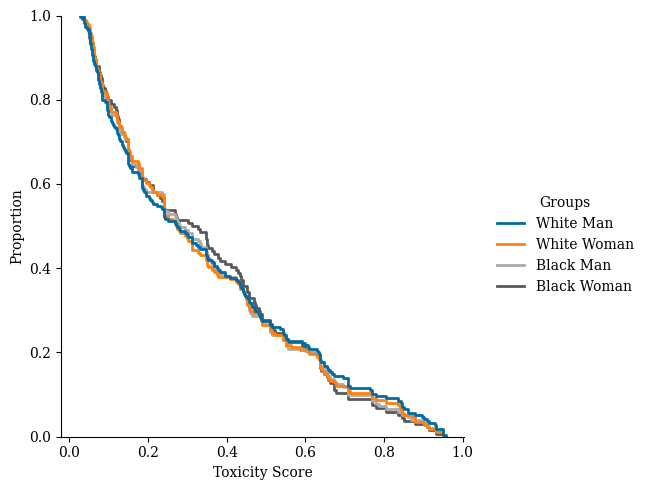

In [415]:
g = sns.displot(data=tmp, x="score", hue="group",kind='ecdf', complementary=True) #dicionario de palavroes do liwcg
plt.xlabel('Toxicity Score')
g.legend.set_title('Groups')
plt.savefig('curse_words_toxicity_distribution.pdf')
plt.show()


In [383]:
stats.kruskal(
        tmp[tmp.group=='White Man']['rank'],
        tmp[tmp.group=='White Woman']['rank'],
        tmp[tmp.group=='Black Man']['rank'],
        tmp[tmp.group=='Black Woman']['score'],
    )

KruskalResult(statistic=0.15114817067526753, pvalue=0.9850612060693186)

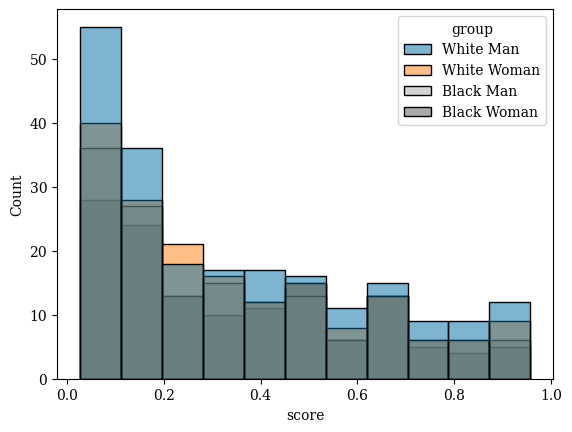

In [380]:
sns.histplot(tmp,x='score',hue='group')
plt.show()

In [501]:
tmp = scores[scores.text.str.contains('|'.join(word_scores[word_scores.score>.2].words))].merge(df[['id','group']])

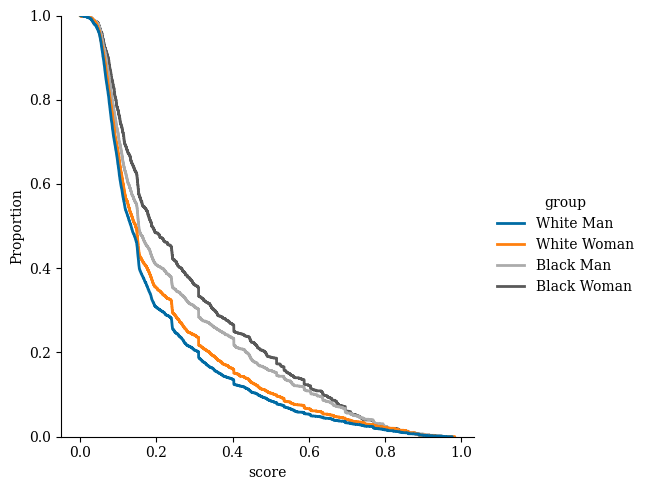

In [502]:
sns.displot(tmp,x='score',hue='group',kind='ecdf',complementary=True)
plt.show()

---

## Relevant features

https://www.liwc.net/LIWC2007LanguageManual.pdf

https://repositories.lib.utexas.edu/bitstream/handle/2152/31333/LIWC2015_LanguageManual.pdf

In [13]:
experiments[experiments['pvalue']<0.05].sort_values('pvalue')

,feature,statistic,pvalue
20,quant,45.429640,7.498099e-10
67,informal,38.059231,2.746028e-08
59,space,37.242565,4.088498e-08
15,verb,37.131304,4.316250e-08
69,netspeak,32.476639,4.152565e-07
57,relativ,32.394058,4.322421e-07
9,article,32.313947,4.493822e-07
13,conj,31.979148,5.286691e-07
19,number,31.956363,5.345469e-07
70,assent,31.594096,6.372621e-07


In [14]:
sns.displot(liwc_df_rank, x="cogproc", hue="group", kind="ecdf",complementary=True) #dicionario de palavroes do liwc
plt.savefig('cogproc.pdf')

### quant

<Figure size 640x480 with 0 Axes>

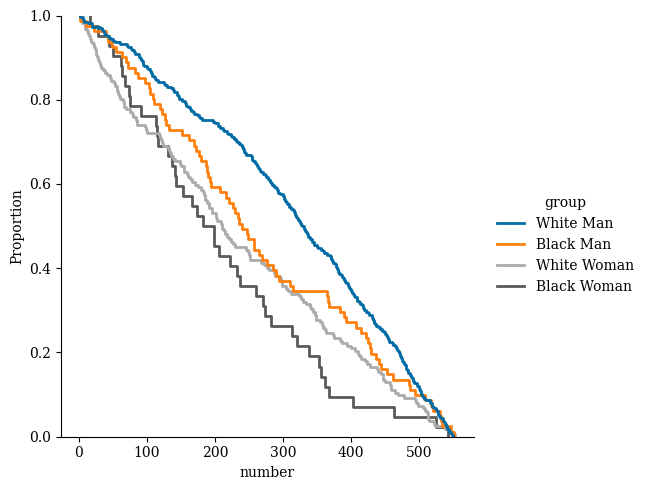

In [287]:
sns.displot(liwc_df_rank, x="number", hue="group", kind="ecdf",complementary=True) #dicionario de palavroes do liwc
plt.show()
plt.savefig('number.pdf')

## Black people use more informalities

<Figure size 640x480 with 0 Axes>

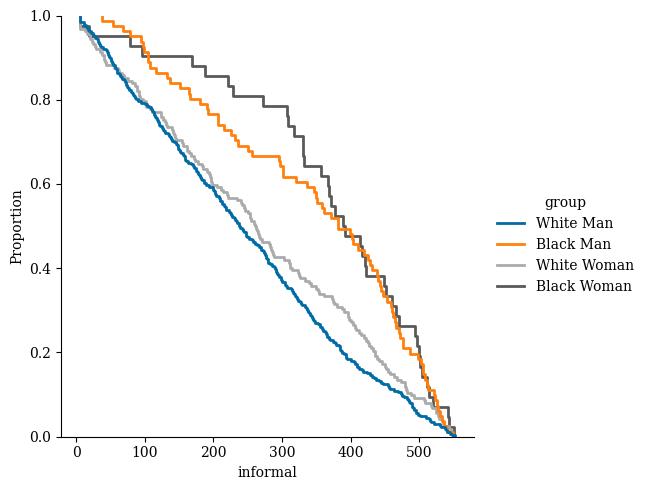

In [269]:
sns.displot(liwc_df_rank, x="informal", hue="group", kind="ecdf",complementary=True) #dicionario de palavroes do liwc
plt.show()
plt.savefig('informal.pdf')

In [16]:
sns.displot(liwc_df_rank, x="netspeak", hue="group", kind="ecdf",complementary=True, legend=False) #dicionario de palavroes do liwc
plt.savefig('netspeak.pdf')

In [17]:
sns.displot(liwc_df_rank, x="assent", hue="group", kind="ecdf",complementary=True, legend=False) #
plt.savefig('assent.pdf')

In [18]:
sns.displot(liwc_df_rank, x="filler", hue="group", kind="ecdf",complementary=True, legend=False) #
plt.savefig('filler.pdf')

In [19]:
display(liwc_df_norm[['informal','group']].groupby('group').mean(),liwc_df_rank[['informal','group']].groupby('group').mean())

,informal
group,
Black Man,0.004713
Black Woman,0.005030
White Man,0.003368
White Woman,0.003668


,informal
group,
Black Man,344.160494
Black Woman,368.559524
White Man,247.206767
White Woman,267.200617


# cogproc

In [20]:
display(liwc_df_norm[['cogproc','group']].groupby('group').mean(),liwc_df_rank[['cogproc','group']].groupby('group').mean())

,cogproc
group,
Black Man,0.041737
Black Woman,0.042310
White Man,0.043198
White Woman,0.044043


,cogproc
group,
Black Man,244.283951
Black Woman,254.011905
White Man,274.783835
White Woman,300.518519


## Others stats 

### swear - fuck, damn, shit

In [21]:
sns.displot(liwc_df_rank, x="swear", hue="group", kind="ecdf",complementary=True, legend=False) #dicionario de palavroes do liwc
plt.savefig('swear.pdf')

In [22]:
display(liwc_df_norm[['swear','group']].groupby('group').mean(),liwc_df_rank[['swear','group']].groupby('group').mean())

,swear
group,
Black Man,0.000406
Black Woman,0.000327
White Man,0.000233
White Woman,0.000270


,swear
group,
Black Man,319.975309
Black Woman,310.595238
White Man,256.112782
White Woman,280.203704


### prep - prepositions - to, with, above 

In [23]:
sns.displot(liwc_df_rank, x="prep", hue="group", kind="ecdf",complementary=True) #dicionario de palavroes do liwc
plt.savefig('prep.pdf')

### anx - worried, fearful

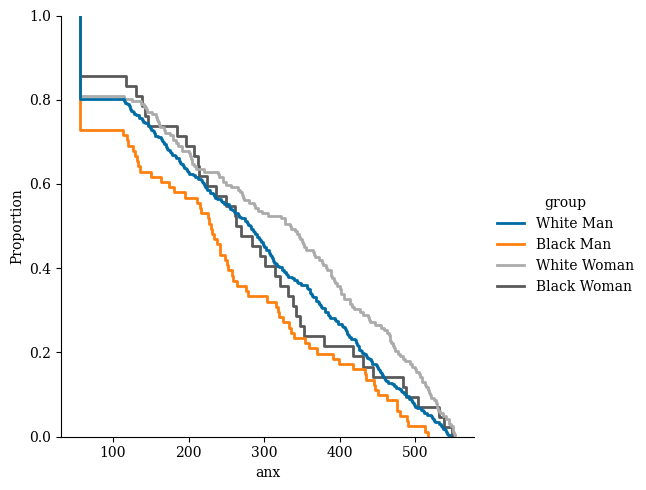

In [133]:
sns.displot(liwc_df_rank, x="anx", hue="group", kind="ecdf",complementary=True) #dicionario de palavroes do liwc
plt.show()

### percept - Perceptual processes - look, heard, feeling 

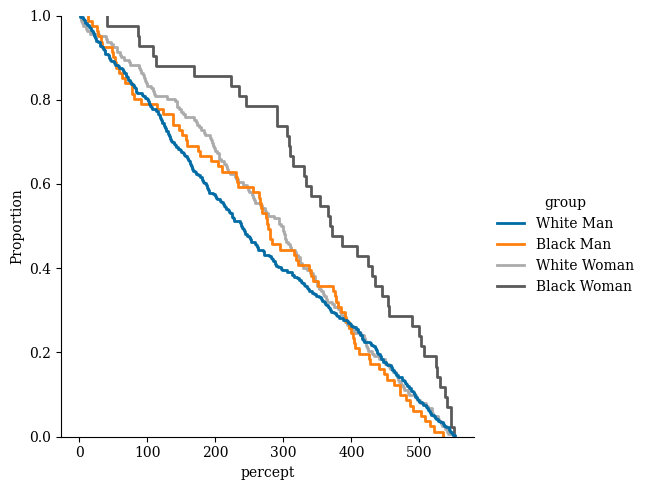

In [134]:
sns.displot(liwc_df_rank, x="percept", hue="group", kind="ecdf",complementary=True) #dicionario de palavroes do liwc
plt.show()

### conj - Conjunctions - and, but, whereas

In [26]:
sns.displot(liwc_df_rank, x="conj", hue="group", kind="ecdf",complementary=True, legend=False) #dicionario de palavroes do liwc
plt.savefig('conj.pdf')

### function - Total function words - it, to, no, very

In [27]:
sns.displot(liwc_df_rank, x="function", hue="group", kind="ecdf",complementary=True, legend=False) #dicionario de palavroes do liwc
plt.savefig('function.pdf')

---
# investigating each category most used words by group

In [152]:
str(list(liwc.parse([word]).keys()))

"['social', 'relativ', 'time']"

In [157]:
categories = ['informal','cogproc', 'swear','anx','percept'] # liwc.categories.values()

groups_counts = {} # pd.DataFrame(columns=['group','category','word','count'])
groups_counts_df = pd.DataFrame(columns=['categories','count','group','word']).set_index(['group','word'])

for group in df.group.unique():
    for sent in tqdm(df[df.group==group]['text_clean'].str.split(' ')):
        for word in sent:
            if (group,word) not in groups_counts_df.index:
                groups_counts_df.loc[(group,word),:] = (str(list(liwc.parse([word]).keys())),1)
            else:
                groups_counts_df.loc[(group,word),'count'] += 1
groups_counts_df = groups_counts_df.reset_index()


100%|██████████| 42/42 [18:15<00:00, 26.08s/it] 


In [195]:
data = json.load(open('../data/bad_words_scored.json'))
word_scores = pd.DataFrame({'words':data.keys(),'score': data.values()})

In [162]:
# groups_counts_df.to_csv('../data/categories_groups_counts_df.csv',index=False)

In [166]:
groups_counts_df

,group,word,categories,count
0,White Man,I,[],6615
1,White Man,saw,"['verb', 'percept', 'see', 'focuspast']",149
2,White Man,black,"['percept', 'see']",120
3,White Man,panther,[],19
4,White Man,and,"['function', 'conj']",12915
...,...,...,...,...
45640,Black Woman,jimmy,[],2
45641,Black Woman,cagne,[],1
45642,Black Woman,jim,[],1
45643,Black Woman,cagney,[],2


### informal

In [199]:
bw_informal = groups_counts_df[
    (groups_counts_df.group=='Black Woman') & (groups_counts_df.categories.str.contains('informal'))
]
bw_informal['freq'] = bw_informal['count']/groups_counts_df[(groups_counts_df.group=='Black Woman')]['count'].sum()
bw_informal.sort_values('count',ascending=False).head(20).merge(word_scores, left_on='word', right_on='words',how='left')

<ipython-input-199-fa7bdd924ab0>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bw_informal['freq'] = bw_informal['count']/groups_counts_df[(groups_counts_df.group=='Black Woman')]['count'].sum()


,group,word,categories,count,freq,words,score
0,Black Woman,oh,"['informal', 'nonflu']",251,0.00296389,NaN,NaN
1,Black Woman,gonna,"['verb', 'focusfuture', 'relativ', 'motion', '...",173,0.00204284,NaN,NaN
2,Black Woman,okay,"['affect', 'posemo', 'informal', 'assent']",155,0.00183029,NaN,NaN
3,Black Woman,well,"['function', 'adverb', 'affect', 'posemo', 'in...",143,0.00168859,NaN,NaN
4,Black Woman,um,"['informal', 'nonflu']",119,0.00140519,NaN,NaN
5,Black Woman,yeah,"['informal', 'assent']",105,0.00123987,NaN,NaN
6,Black Woman,yes,"['informal', 'assent']",45,0.000531375,NaN,NaN
7,Black Woman,cool,"['adj', 'affect', 'posemo', 'percept', 'feel',...",29,0.000342441,NaN,NaN
8,Black Woman,hey,"['social', 'informal']",29,0.000342441,NaN,NaN
9,Black Woman,absolutely,"['function', 'adverb', 'cogproc', 'certain', '...",27,0.000318825,NaN,NaN


In [200]:
wm_informal = groups_counts_df[
    (groups_counts_df.group=='White Man') & (groups_counts_df.categories.str.contains('informal'))
]
wm_informal['freq'] = wm_informal['count']/groups_counts_df[(groups_counts_df.group=='White Man')]['count'].sum()
wm_informal.sort_values('count',ascending=False).head(20).merge(word_scores, left_on='word', right_on='words',how='left')

<ipython-input-200-57f1bdac38f0>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  wm_informal['freq'] = wm_informal['count']/groups_counts_df[(groups_counts_df.group=='White Man')]['count'].sum()


,group,word,categories,count,freq,words,score
0,White Man,well,"['function', 'adverb', 'affect', 'posemo', 'in...",864,0.00235558,NaN,NaN
1,White Man,gonna,"['verb', 'focusfuture', 'relativ', 'motion', '...",565,0.0015404,NaN,NaN
2,White Man,yeah,"['informal', 'assent']",301,0.000820638,NaN,NaN
3,White Man,uh,"['informal', 'nonflu']",202,0.000550727,NaN,NaN
4,White Man,um,"['informal', 'nonflu']",199,0.000542548,NaN,NaN
5,White Man,oh,"['informal', 'nonflu']",195,0.000531642,NaN,NaN
6,White Man,absolutely,"['function', 'adverb', 'cogproc', 'certain', '...",174,0.000474388,NaN,NaN
7,White Man,okay,"['affect', 'posemo', 'informal', 'assent']",141,0.000384418,NaN,NaN
8,White Man,cool,"['adj', 'affect', 'posemo', 'percept', 'feel',...",110,0.000299901,NaN,NaN
9,White Man,yes,"['informal', 'assent']",108,0.000294448,NaN,NaN


### swear

In [201]:
wm_informal = groups_counts_df[
    (groups_counts_df.group=='Black Woman') & (groups_counts_df.categories.str.contains('swear'))
]
wm_informal['freq'] = wm_informal['count']/groups_counts_df[(groups_counts_df.group=='Black Woman')]['count'].sum()
wm_informal.sort_values('count',ascending=False).head(20).merge(word_scores, left_on='word', right_on='words',how='left')

<ipython-input-201-2d8500db1ce1>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  wm_informal['freq'] = wm_informal['count']/groups_counts_df[(groups_counts_df.group=='Black Woman')]['count'].sum()


,group,word,categories,count,freq,words,score
0,Black Woman,freaking,"['affect', 'negemo', 'informal', 'swear']",16,0.000188933,NaN,NaN
1,Black Woman,damn,"['affect', 'negemo', 'anger', 'informal', 'swe...",12,0.0001417,damn,0.779738
2,Black Woman,hell,"['affect', 'negemo', 'anger', 'relig', 'inform...",8,9.44666e-05,hell,0.483667
3,Black Woman,sucks,"['verb', 'affect', 'negemo', 'anger', 'focuspr...",5,5.90416e-05,NaN,NaN
4,Black Woman,badass,"['informal', 'swear']",5,5.90416e-05,NaN,NaN
5,Black Woman,dumb,"['adj', 'affect', 'negemo', 'anger', 'informal...",5,5.90416e-05,dumb,0.845482
6,Black Woman,dang,"['informal', 'swear']",4,4.72333e-05,NaN,NaN
7,Black Woman,freakin,"['affect', 'negemo', 'informal', 'swear']",4,4.72333e-05,NaN,NaN
8,Black Woman,sucked,"['verb', 'affect', 'negemo', 'anger', 'focuspa...",4,4.72333e-05,NaN,NaN
9,Black Woman,ass,"['bio', 'body', 'informal', 'swear']",2,2.36167e-05,ass,0.932329


In [203]:
wm_informal = groups_counts_df[
    (groups_counts_df.group=='White Woman') & (groups_counts_df.categories.str.contains('swear'))
]
wm_informal['freq'] = wm_informal['count']/groups_counts_df[(groups_counts_df.group=='White Woman')]['count'].sum()
wm_informal.sort_values('count',ascending=False).head(20).merge(word_scores, left_on='word', right_on='words',how='left')

<ipython-input-203-b17cb5e83f6b>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  wm_informal['freq'] = wm_informal['count']/groups_counts_df[(groups_counts_df.group=='White Woman')]['count'].sum()


,group,word,categories,count,freq,words,score
0,White Woman,badass,"['informal', 'swear']",19,7.90412e-05,NaN,NaN
1,White Woman,damn,"['affect', 'negemo', 'anger', 'informal', 'swe...",13,5.40808e-05,damn,0.779738
2,White Woman,hell,"['affect', 'negemo', 'anger', 'relig', 'inform...",12,4.99208e-05,hell,0.483667
3,White Woman,ass,"['bio', 'body', 'informal', 'swear']",12,4.99208e-05,ass,0.932329
4,White Woman,heck,"['informal', 'swear']",12,4.99208e-05,NaN,NaN
5,White Woman,butt,"['bio', 'body', 'informal', 'swear']",9,3.74406e-05,butt,0.769914
6,White Woman,freaking,"['affect', 'negemo', 'informal', 'swear']",9,3.74406e-05,NaN,NaN
7,White Woman,sucked,"['verb', 'affect', 'negemo', 'anger', 'focuspa...",9,3.74406e-05,NaN,NaN
8,White Woman,shitty,"['affect', 'negemo', 'anger', 'bio', 'body', '...",9,3.74406e-05,shitty,0.949928
9,White Woman,hella,"['informal', 'swear', 'netspeak']",9,3.74406e-05,NaN,NaN


### cogproc

In [212]:
wm_informal = groups_counts_df[
    (groups_counts_df.group=='Black Woman') & (groups_counts_df.categories.str.contains('cogproc'))
]
wm_informal['freq'] = wm_informal['count']/groups_counts_df[(groups_counts_df.group=='Black Woman')]['count'].sum()
wm_informal.sort_values('count',ascending=False).head(20).merge(word_scores, left_on='word', right_on='words',how='left')

<ipython-input-212-e4a29866a6bd>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  wm_informal['freq'] = wm_informal['count']/groups_counts_df[(groups_counts_df.group=='Black Woman')]['count'].sum()


,group,word,categories,count,freq,words,score
0,Black Woman,know,"['verb', 'cogproc', 'insight', 'focuspresent']",646,0.00762818,NaN,NaN
1,Black Woman,but,"['function', 'conj', 'cogproc', 'differ']",643,0.00759275,NaN,NaN
2,Black Woman,really,"['function', 'adverb', 'cogproc', 'differ']",489,0.00577427,NaN,NaN
3,Black Woman,not,"['function', 'negate', 'cogproc', 'differ']",456,0.0053846,NaN,NaN
4,Black Woman,because,"['function', 'conj', 'cogproc', 'cause']",393,0.00464067,NaN,NaN
5,Black Woman,all,"['quant', 'cogproc', 'certain']",337,0.00397941,NaN,NaN
6,Black Woman,if,"['function', 'conj', 'cogproc', 'discrep', 'te...",309,0.00364877,NaN,NaN
7,Black Woman,think,"['verb', 'cogproc', 'insight', 'focuspresent']",268,0.00316463,NaN,NaN
8,Black Woman,how,"['function', 'adverb', 'conj', 'interrog', 'co...",251,0.00296389,NaN,NaN
9,Black Woman,or,"['function', 'conj', 'cogproc', 'tentat', 'dif...",230,0.00271592,NaN,NaN


In [213]:
wm_informal = groups_counts_df[
    (groups_counts_df.group=='White Man') & (groups_counts_df.categories.str.contains('cogproc'))
]
wm_informal['freq'] = wm_informal['count']/groups_counts_df[(groups_counts_df.group=='White Man')]['count'].sum()
wm_informal.sort_values('count',ascending=False).head(20).merge(word_scores, left_on='word', right_on='words',how='left')

<ipython-input-213-8cb6bfc60f3c>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  wm_informal['freq'] = wm_informal['count']/groups_counts_df[(groups_counts_df.group=='White Man')]['count'].sum()


,group,word,categories,count,freq,words,score
0,White Man,but,"['function', 'conj', 'cogproc', 'differ']",2934,0.00799917,NaN,NaN
1,White Man,really,"['function', 'adverb', 'cogproc', 'differ']",2529,0.00689499,NaN,NaN
2,White Man,know,"['verb', 'cogproc', 'insight', 'focuspresent']",1989,0.00542275,NaN,NaN
3,White Man,not,"['function', 'negate', 'cogproc', 'differ']",1653,0.00450669,NaN,NaN
4,White Man,all,"['quant', 'cogproc', 'certain']",1573,0.00428858,NaN,NaN
5,White Man,because,"['function', 'conj', 'cogproc', 'cause']",1327,0.00361789,NaN,NaN
6,White Man,think,"['verb', 'cogproc', 'insight', 'focuspresent']",1316,0.0035879,NaN,NaN
7,White Man,if,"['function', 'conj', 'cogproc', 'discrep', 'te...",1231,0.00335616,NaN,NaN
8,White Man,or,"['function', 'conj', 'cogproc', 'tentat', 'dif...",1064,0.00290086,NaN,NaN
9,White Man,some,"['quant', 'cogproc', 'tentat']",1029,0.00280544,NaN,NaN


### anx

In [215]:
wm_informal = groups_counts_df[
    (groups_counts_df.group=='Black Woman') & (groups_counts_df.categories.str.contains('anx'))
]
wm_informal['freq'] = wm_informal['count']/groups_counts_df[(groups_counts_df.group=='Black Woman')]['count'].sum()
wm_informal.sort_values('count',ascending=False).head(20).merge(word_scores, left_on='word', right_on='words',how='left')

<ipython-input-215-64f77ba7253e>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  wm_informal['freq'] = wm_informal['count']/groups_counts_df[(groups_counts_df.group=='Black Woman')]['count'].sum()


,group,word,categories,count,freq,words,score
0,Black Woman,scary,"['adj', 'affect', 'negemo', 'anx']",32,0.000377866,NaN,NaN
1,Black Woman,horror,"['affect', 'negemo', 'anx']",29,0.000342441,NaN,NaN
2,Black Woman,fear,"['affect', 'negemo', 'anx']",14,0.000165317,fear,0.142798
3,Black Woman,scared,"['adj', 'affect', 'negemo', 'anx']",11,0.000129892,NaN,NaN
4,Black Woman,shy,"['adj', 'affect', 'negemo', 'anx', 'social']",9,0.000106275,NaN,NaN
5,Black Woman,uncomfortable,"['affect', 'negemo', 'anx']",6,7.085e-05,NaN,NaN
6,Black Woman,terrifying,"['adj', 'affect', 'negemo', 'anx']",6,7.085e-05,NaN,NaN
7,Black Woman,horrible,"['adj', 'affect', 'negemo', 'anx']",5,5.90416e-05,NaN,NaN
8,Black Woman,shook,"['verb', 'affect', 'negemo', 'anx', 'focuspast...",5,5.90416e-05,NaN,NaN
9,Black Woman,afraid,"['adj', 'affect', 'negemo', 'anx']",5,5.90416e-05,NaN,NaN


In [216]:
wm_informal = groups_counts_df[
    (groups_counts_df.group=='White Woman') & (groups_counts_df.categories.str.contains('anx'))
]
wm_informal['freq'] = wm_informal['count']/groups_counts_df[(groups_counts_df.group=='White Man')]['count'].sum()
wm_informal.sort_values('count',ascending=False).head(20).merge(word_scores, left_on='word', right_on='words',how='left')

<ipython-input-216-c228f5d16615>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  wm_informal['freq'] = wm_informal['count']/groups_counts_df[(groups_counts_df.group=='White Man')]['count'].sum()


,group,word,categories,count,freq,words,score
0,White Woman,horror,"['affect', 'negemo', 'anx']",134,0.000365334,NaN,NaN
1,White Woman,tension,"['affect', 'negemo', 'anx']",59,0.000160856,NaN,NaN
2,White Woman,worry,"['verb', 'affect', 'negemo', 'anx', 'focuspres...",28,7.63384e-05,NaN,NaN
3,White Woman,scary,"['adj', 'affect', 'negemo', 'anx']",26,7.08856e-05,NaN,NaN
4,White Woman,fear,"['affect', 'negemo', 'anx']",22,5.99802e-05,fear,0.142798
5,White Woman,awkward,"['affect', 'negemo', 'anx', 'social']",21,5.72538e-05,NaN,NaN
6,White Woman,worried,"['adj', 'affect', 'negemo', 'anx']",18,4.90747e-05,NaN,NaN
7,White Woman,uncomfortable,"['affect', 'negemo', 'anx']",17,4.63483e-05,NaN,NaN
8,White Woman,terrifying,"['adj', 'affect', 'negemo', 'anx']",17,4.63483e-05,NaN,NaN
9,White Woman,struggling,"['affect', 'negemo', 'anx', 'drives', 'power']",16,4.36219e-05,NaN,NaN


### quant

In [290]:
wm_informal = groups_counts_df[
    (groups_counts_df.group=='Black Woman') & groups_counts_df.categories.str.contains('informal') & groups_counts_df.categories.str.contains('swear')
]
wm_informal['freq'] = wm_informal['count']/groups_counts_df[(groups_counts_df.group=='Black Woman')]['count'].sum()
wm_informal.sort_values('count',ascending=False).head(30).merge(word_scores, left_on='word', right_on='words',how='left')

<ipython-input-290-9e461a842f48>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  wm_informal['freq'] = wm_informal['count']/groups_counts_df[(groups_counts_df.group=='Black Woman')]['count'].sum()


,group,word,categories,count,freq,words,score,stem
0,Black Woman,freaking,"['affect', 'negemo', 'informal', 'swear']",16,0.000188933,NaN,NaN,NaN
1,Black Woman,damn,"['affect', 'negemo', 'anger', 'informal', 'swe...",12,0.0001417,damn,0.779738,damn
2,Black Woman,hell,"['affect', 'negemo', 'anger', 'relig', 'inform...",8,9.44666e-05,hell,0.483667,hell
3,Black Woman,sucks,"['verb', 'affect', 'negemo', 'anger', 'focuspr...",5,5.90416e-05,NaN,NaN,NaN
4,Black Woman,badass,"['informal', 'swear']",5,5.90416e-05,NaN,NaN,NaN
5,Black Woman,dumb,"['adj', 'affect', 'negemo', 'anger', 'informal...",5,5.90416e-05,dumb,0.845482,dumb
6,Black Woman,dang,"['informal', 'swear']",4,4.72333e-05,NaN,NaN,NaN
7,Black Woman,freakin,"['affect', 'negemo', 'informal', 'swear']",4,4.72333e-05,NaN,NaN,NaN
8,Black Woman,sucked,"['verb', 'affect', 'negemo', 'anger', 'focuspa...",4,4.72333e-05,NaN,NaN,NaN
9,Black Woman,ass,"['bio', 'body', 'informal', 'swear']",2,2.36167e-05,ass,0.932329,ass


In [292]:
wm_informal = groups_counts_df[
    (groups_counts_df.group=='White Woman') & (groups_counts_df.categories.str.contains('informal')) & groups_counts_df.categories.str.contains('swear')
]
wm_informal['freq'] = wm_informal['count']/groups_counts_df[(groups_counts_df.group=='White Man')]['count'].sum()
wm_informal.sort_values('count',ascending=False).head(30).merge(word_scores, left_on='word', right_on='words',how='left')

<ipython-input-292-2801b55c5b3b>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  wm_informal['freq'] = wm_informal['count']/groups_counts_df[(groups_counts_df.group=='White Man')]['count'].sum()


,group,word,categories,count,freq,words,score,stem
0,White Woman,badass,"['informal', 'swear']",19,5.1801e-05,NaN,NaN,NaN
1,White Woman,damn,"['affect', 'negemo', 'anger', 'informal', 'swe...",13,3.54428e-05,damn,0.779738,damn
2,White Woman,hell,"['affect', 'negemo', 'anger', 'relig', 'inform...",12,3.27164e-05,hell,0.483667,hell
3,White Woman,ass,"['bio', 'body', 'informal', 'swear']",12,3.27164e-05,ass,0.932329,ass
4,White Woman,heck,"['informal', 'swear']",12,3.27164e-05,NaN,NaN,NaN
5,White Woman,butt,"['bio', 'body', 'informal', 'swear']",9,2.45373e-05,butt,0.769914,butt
6,White Woman,freaking,"['affect', 'negemo', 'informal', 'swear']",9,2.45373e-05,NaN,NaN,NaN
7,White Woman,sucked,"['verb', 'affect', 'negemo', 'anger', 'focuspa...",9,2.45373e-05,NaN,NaN,NaN
8,White Woman,shitty,"['affect', 'negemo', 'anger', 'bio', 'body', '...",9,2.45373e-05,shitty,0.949928,shitti
9,White Woman,hella,"['informal', 'swear', 'netspeak']",9,2.45373e-05,NaN,NaN,NaN


---
# radar plot

In [24]:
import numpy as np

import matplotlib.pyplot as plt
from matplotlib.patches import Circle, RegularPolygon
from matplotlib.path import Path
from matplotlib.projections.polar import PolarAxes
from matplotlib.projections import register_projection
from matplotlib.spines import Spine
from matplotlib.transforms import Affine2D


def radar_factory(num_vars, frame='circle'):
    """
    Create a radar chart with `num_vars` axes.

    This function creates a RadarAxes projection and registers it.

    Parameters
    ----------
    num_vars : int
        Number of variables for radar chart.
    frame : {'circle', 'polygon'}
        Shape of frame surrounding axes.

    """
    # calculate evenly-spaced axis angles
    theta = np.linspace(0, 2*np.pi, num_vars, endpoint=False)

    class RadarAxes(PolarAxes):

        name = 'radar'
        # use 1 line segment to connect specified points
        RESOLUTION = 1

        def __init__(self, *args, **kwargs):
            super().__init__(*args, **kwargs)
            # rotate plot such that the first axis is at the top
            self.set_theta_zero_location('N')

        def fill(self, *args, closed=True, **kwargs):
            """Override fill so that line is closed by default"""
            return super().fill(closed=closed, *args, **kwargs)

        def plot(self, *args, **kwargs):
            """Override plot so that line is closed by default"""
            lines = super().plot(*args, **kwargs)
            for line in lines:
                self._close_line(line)

        def _close_line(self, line):
            x, y = line.get_data()
            # FIXME: markers at x[0], y[0] get doubled-up
            if x[0] != x[-1]:
                x = np.append(x, x[0])
                y = np.append(y, y[0])
                line.set_data(x, y)

        def set_varlabels(self, labels):
            self.set_thetagrids(np.degrees(theta), labels)

        def _gen_axes_patch(self):
            # The Axes patch must be centered at (0.5, 0.5) and of radius 0.5
            # in axes coordinates.
            if frame == 'circle':
                return Circle((0.5, 0.5), 0.5)
            elif frame == 'polygon':
                return RegularPolygon((0.5, 0.5), num_vars,
                                      radius=.5, edgecolor="k")
            else:
                raise ValueError("Unknown value for 'frame': %s" % frame)

        def _gen_axes_spines(self):
            if frame == 'circle':
                return super()._gen_axes_spines()
            elif frame == 'polygon':
                # spine_type must be 'left'/'right'/'top'/'bottom'/'circle'.
                spine = Spine(axes=self,
                              spine_type='circle',
                              path=Path.unit_regular_polygon(num_vars))
                # unit_regular_polygon gives a polygon of radius 1 centered at
                # (0, 0) but we want a polygon of radius 0.5 centered at (0.5,
                # 0.5) in axes coordinates.
                spine.set_transform(Affine2D().scale(.5).translate(.5, .5)
                                    + self.transAxes)
                return {'polar': spine}
            else:
                raise ValueError("Unknown value for 'frame': %s" % frame)

    register_projection(RadarAxes)
    return theta


def example_data():
    # The following data is from the Denver Aerosol Sources and Health study.
    # See doi:10.1016/j.atmosenv.2008.12.017
    #
    # The data are pollution source profile estimates for five modeled
    # pollution sources (e.g., cars, wood-burning, etc) that emit 7-9 chemical
    # species. The radar charts are experimented with here to see if we can
    # nicely visualize how the modeled source profiles change across four
    # scenarios:
    #  1) No gas-phase species present, just seven particulate counts on
    #     Sulfate
    #     Nitrate
    #     Elemental Carbon (EC)
    #     Organic Carbon fraction 1 (OC)
    #     Organic Carbon fraction 2 (OC2)
    #     Organic Carbon fraction 3 (OC3)
    #     Pyrolized Organic Carbon (OP)
    #  2)Inclusion of gas-phase specie carbon monoxide (CO)
    #  3)Inclusion of gas-phase specie ozone (O3).
    #  4)Inclusion of both gas-phase species is present...
    data = [
        ['Sulfate', 'Nitrate', 'EC', 'OC1', 'OC2', 'OC3', 'OP', 'CO', 'O3'],
        ('Basecase', [
            [0.88, 0.01, 0.03, 0.03, 0.00, 0.06, 0.01, 0.00, 0.00],
            [0.07, 0.95, 0.04, 0.05, 0.00, 0.02, 0.01, 0.00, 0.00],
            [0.01, 0.02, 0.85, 0.19, 0.05, 0.10, 0.00, 0.00, 0.00],
            [0.02, 0.01, 0.07, 0.01, 0.21, 0.12, 0.98, 0.00, 0.00],
            [0.01, 0.01, 0.02, 0.71, 0.74, 0.70, 0.00, 0.00, 0.00]]),
        ('With CO', [
            [0.88, 0.02, 0.02, 0.02, 0.00, 0.05, 0.00, 0.05, 0.00],
            [0.08, 0.94, 0.04, 0.02, 0.00, 0.01, 0.12, 0.04, 0.00],
            [0.01, 0.01, 0.79, 0.10, 0.00, 0.05, 0.00, 0.31, 0.00],
            [0.00, 0.02, 0.03, 0.38, 0.31, 0.31, 0.00, 0.59, 0.00],
            [0.02, 0.02, 0.11, 0.47, 0.69, 0.58, 0.88, 0.00, 0.00]]),
        ('With O3', [
            [0.89, 0.01, 0.07, 0.00, 0.00, 0.05, 0.00, 0.00, 0.03],
            [0.07, 0.95, 0.05, 0.04, 0.00, 0.02, 0.12, 0.00, 0.00],
            [0.01, 0.02, 0.86, 0.27, 0.16, 0.19, 0.00, 0.00, 0.00],
            [0.01, 0.03, 0.00, 0.32, 0.29, 0.27, 0.00, 0.00, 0.95],
            [0.02, 0.00, 0.03, 0.37, 0.56, 0.47, 0.87, 0.00, 0.00]]),
        ('CO & O3', [
            [0.87, 0.01, 0.08, 0.00, 0.00, 0.04, 0.00, 0.00, 0.01],
            [0.09, 0.95, 0.02, 0.03, 0.00, 0.01, 0.13, 0.06, 0.00],
            [0.01, 0.02, 0.71, 0.24, 0.13, 0.16, 0.00, 0.50, 0.00],
            [0.01, 0.03, 0.00, 0.28, 0.24, 0.23, 0.00, 0.44, 0.88],
            [0.02, 0.00, 0.18, 0.45, 0.64, 0.55, 0.86, 0.00, 0.16]])
    ]
    return data



N = 9
theta = radar_factory(N, frame='polygon')

data = example_data()
spoke_labels = data.pop(0)

fig, ax = plt.subplots(figsize=(9, 9), nrows=1, ncols=1,
                        subplot_kw=dict(projection='radar'))
fig.subplots_adjust(wspace=0.25, hspace=0.20, top=0.85, bottom=0.05)

colors = ['b', 'r', 'g', 'm', 'y']
# Plot the four cases from the example data on separate axes

ax.set_rgrids([0.2, 0.4, 0.6, 0.8])
ax.set_title(title, weight='bold', size='medium', position=(0.5, 1.1),
             horizontalalignment='center', verticalalignment='center')
for d, color in zip(case_data, colors):
    ax.plot(theta, d, color=color)
    ax.fill(theta, d, facecolor=color, alpha=0.25)
ax.set_varlabels(spoke_labels)

# add legend relative to top-left plot
labels = ('Factor 1', 'Factor 2', 'Factor 3', 'Factor 4', 'Factor 5')
legend = ax.legend(labels, loc=(0.9, .95),
                          labelspacing=0.1, fontsize='small')

fig.text(0.5, 0.965, '5-Factor Solution Profiles Across Four Scenarios',
         horizontalalignment='center', color='black', weight='bold',
         size='large')

plt.show()


NameError: name 'title' is not defined

---

# Diferences between groups on toxicity score

### Kruskal-wallis test

In [12]:
result = stats.kruskal(
        df[df.group=='White Man']['score'],
        df[df.group=='White Woman']['score'],
        df[df.group=='Black Man']['score'],
        df[df.group=='Black Woman']['score'],
    )
result

KeyError: 'score'

In [ ]:
sns.displot(df, x="score", hue="group", kind="ecdf",complementary=True) #checar o que sao adjetivos

---

# Bad Words

In [192]:
data = json.load(open('../data/bad_words_scored.json'))
word_scores = pd.DataFrame({'words':data.keys(),'score': data.values()})
bad_words = word_scores[word_scores.score>0.2]

In [235]:
import nltk
sno = nltk.stem.SnowballStemmer('english')
word_scores['stem'] = word_scores['words'].apply(lambda x: sno.stem(x)) 
word_scores

In [239]:

bad_words_counts_df_steam = pd.DataFrame(columns=['count','group','bad_word']).set_index(['group','bad_word'])

for group in df.group.unique():
    for sent in tqdm(df[df.group==group]['text_clean'].str.split(' ')):
        for word in sent:
            if (sno.stem(word) ==word_scores.stem).any():
                if (group,word) not in bad_words_counts_df_steam.index:
                    bad_words_counts_df_steam.loc[(group,word),'count'] = 1
                else:
                    bad_words_counts_df_steam.loc[(group,word),'count'] += 1
bad_words_counts_df_steam = bad_words_counts_df_steam.reset_index()

100%|██████████| 42/42 [00:19<00:00,  2.16it/s]


In [241]:
bad_words_counts_df_steam.reset_index()

,index,group,bad_word,count
0,0,White Man,black,120
1,1,White Man,dead,47
2,2,White Man,kill,22
3,3,White Man,Black,45
4,4,White Man,killed,17
...,...,...,...,...
1288,1288,Black Woman,lied,2
1289,1289,Black Woman,Asians,1
1290,1290,Black Woman,disease,1
1291,1291,Black Woman,blows,1


In [228]:

bad_words_counts_df = pd.DataFrame(columns=['count','group','bad_word']).set_index(['group','bad_word'])

for group in df.group.unique():
    for sent in tqdm(df[df.group==group]['text_clean'].str.split(' ')):
        for word in sent:
            if (word ==word_scores.words).any():
                if (group,word) not in bad_words_counts_df.index:
                    bad_words_counts_df.loc[(group,word),'count'] = 1
                else:
                    bad_words_counts_df.loc[(group,word),'count'] += 1
bad_words_counts_df = bad_words_counts_df.reset_index()

100%|██████████| 42/42 [00:19<00:00,  2.18it/s]


In [254]:
for group in df.group.unique():
    bad_words_counts_df.loc[bad_words_counts_df.group==group,'freq'] = (
        bad_words_counts_df[bad_words_counts_df.group==group]['count']
        /
        groups_counts_df[groups_counts_df.group==group]['count'].sum()
    )

In [263]:
bad_words_counts_df = bad_words_counts_df.merge(word_scores, left_on='bad_word',right_on='words')[['group','bad_word','count','freq','score']]

In [266]:
bad_words_counts_df[bad_words_counts_df.score>0.2].sort_values('freq',ascending=False).groupby('group').head(10).sort_values(['group','freq'],ascending=False)

,group,bad_word,count,freq,score
2,White Woman,black,92,0.000382726,0.348820
6,White Woman,dead,41,0.000170563,0.441481
121,White Woman,death,41,0.000170563,0.636407
78,White Woman,die,28,0.000116482,0.709312
139,White Woman,murder,26,0.000108162,0.605843
181,White Woman,violence,21,8.73613e-05,0.353454
228,White Woman,fire,19,7.90412e-05,0.301820
106,White Woman,died,16,6.6561e-05,0.363736
14,White Woman,killed,16,6.6561e-05,0.664008
67,White Woman,stupid,15,6.24009e-05,0.914704


In [293]:
bad_words_counts_df[bad_words_counts_df.bad_word=='dope']

,group,bad_word,count,freq,score
321,White Man,dope,5,1.36319e-05,0.489401
322,Black Man,dope,33,0.000246322,0.489401
323,White Woman,dope,1,4.16006e-06,0.489401
324,Black Woman,dope,3,3.5425e-05,0.489401


In [307]:
bad_words_counts_df['normalized_score'] = bad_words_counts_df['freq'] * bad_words_counts_df['score']
bad_words_counts_df['normalized_score'] = bad_words_counts_df['normalized_score'].astype(float)

In [309]:
bad_words_counts_df.groupby('group',as_index=False).sum()

,group,score,normalized_score
0,Black Man,49.243228,0.002319
1,Black Woman,44.644553,0.002536
2,White Man,67.904789,0.001650
3,White Woman,58.857698,0.001687


In [157]:
bad_words_counts_df[bad_words_counts_df.score>.2].groupby('group').mean()

,count,freq,score,normalized_score
group,,,,
Black Man,6.400000,0.000048,0.515693,0.000025
Black Woman,5.197368,0.000061,0.523251,0.000030
White Man,9.097345,0.000025,0.528616,0.000013
White Woman,6.663462,0.000028,0.506093,0.000014


In [156]:
bad_words_counts_df

,group,bad_word,count,freq,score,normalized_score
0,White Man,black,120,0.000327,0.348820,0.000114
1,Black Man,black,112,0.000836,0.348820,0.000292
2,White Woman,black,92,0.000383,0.348820,0.000134
3,Black Woman,black,137,0.001618,0.348820,0.000564
4,White Man,dead,47,0.000128,0.441481,0.000057
...,...,...,...,...,...,...
610,Black Woman,snatch,1,0.000012,0.149999,0.000002
611,Black Woman,bestiality,1,0.000012,0.516954,0.000006
612,Black Woman,slimeball,1,0.000012,0.441980,0.000005
613,Black Woman,fondle,1,0.000012,0.092673,0.000001


In [172]:
tmp.groupby('')

,group,bad_word,count,freq,score,normalized_score
0,White Man,black,120,0.000327,0.348820,0.114122
1,Black Man,black,112,0.000836,0.348820,0.291614
2,White Woman,black,92,0.000383,0.348820,0.133502
3,Black Woman,black,137,0.001618,0.348820,0.564301
4,White Man,dead,47,0.000128,0.441481,0.056571
...,...,...,...,...,...,...
608,Black Woman,nude,1,0.000012,0.384367,0.004539
609,Black Woman,fetish,1,0.000012,0.239811,0.002832
611,Black Woman,bestiality,1,0.000012,0.516954,0.006104
612,Black Woman,slimeball,1,0.000012,0.441980,0.005219


In [177]:
tmp = bad_words_counts_df[bad_words_counts_df.score>.2]
tmp['normalized_score'] = tmp['normalized_score']*1000
tmp['normalized_score'] = tmp['normalized_score'].fillna(0)

sns.displot(tmp[tmp.score>.2],x='normalized_score',hue='group',kind='ecdf',log=True)
plt.show()

<ipython-input-177-36e139980111>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tmp['normalized_score'] = tmp['normalized_score']*1000
<ipython-input-177-36e139980111>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tmp['normalized_score'] = tmp['normalized_score'].fillna(0)


AttributeError: 'Line2D' object has no property 'log'

0      0.000114
1      0.000292
2      0.000134
3      0.000564
4      0.000057
         ...   
610    0.000002
611    0.000006
612    0.000005
613    0.000001
614    0.000010
Name: normalized_score, Length: 615, dtype: float64

In [185]:
def get_word_count(text, word):
    text_s = pd.Series(text.split(' '))
    return (text_s==word).sum()

def get_bad_words_count(text, bad_words):
    total=0
    for bad_word in bad_words:
        total +=get_word_count(text,bad_word)
    return total

In [186]:
df['bad_words_count'] = df['text_clean'].apply(get_bad_words_count,args=(bad_words.words,)) 

KeyboardInterrupt: 

In [16]:
display(sns.lmplot(col="group", hue="group", data=df,x='bad_words_count',y='score'))
display(sns.lmplot(data=df,x='bad_words_count',y='score'))

KeyError: "['score'] not in index"

## Person correlation

In [ ]:
print('For all data:', scipy.stats.pearsonr(df.bad_words_count,df.score))

for group in df.group.unique():
    print('For {}:'.format(group), scipy.stats.pearsonr(df[df.group==group].bad_words_count, df[df.group==group].score))

## Spearman correlation

In [ ]:
print('For all data:', scipy.stats.spearmanr(df.bad_words_count,df.score))

for group in df.group.unique():
    print('For {}:'.format(group), scipy.stats.spearmanr(df[df.group==group].bad_words_count, df[df.group==group].score))

### Kruskal-Wallis on bad words count

In [ ]:
result = stats.kruskal(
        df[df.group=='White Man']['bad_words_count'],
        df[df.group=='White Woman']['bad_words_count'],
        df[df.group=='Black Man']['bad_words_count'],
        df[df.group=='Black Woman']['bad_words_count'],
    )
result

In [ ]:
sns.displot(df, x="bad_words_count", hue="group", kind="ecdf",complementary=True) #checar o que sao adjetivos

---

# Words relation - bad words

In [ ]:
bad_words = word_scores[word_scores.score>0.2]

bad_words = bad_words.set_index('words')
bad_words['White Man'] = np.nan
bad_words['Black Man'] = np.nan
bad_words['White Woman'] = np.nan
bad_words['Black Woman'] = np.nan

for bad_word in tqdm(bad_words.index):
    for group in df.group.unique():
        total = 0
        for sent in df[df.group==group].text_clean:
             total += get_word_count(sent,bad_word)
        bad_words.loc[bad_word,group] = total
            
# bad_words = bad_words.reset_index()

In [ ]:
display(bad_words['White Man'].sort_values(ascending=False).head(20))
display(bad_words['White Woman'].sort_values(ascending=False).head(20))
display(bad_words['Black Man'].sort_values(ascending=False).head(20))
display(bad_words['Black Woman'].sort_values(ascending=False).head(20))

### Word: dope - Black Man

In [ ]:
before,after = get_word_relations('dope', df[df['group']=="Black Man"].text_clean)

In [ ]:
display(before,after)

### Word: damn - Black Woman

In [ ]:
a,b = get_word_relations('damn', df[df['group']=="Black Woman"].text_clean)

In [ ]:
display(a,b)

### Word: gay - Black Woman

In [ ]:
a,b = get_word_relations('gay', df[df['group']=="Black Woman"].text_clean)

In [ ]:
display(a,b)

### Word: extra

In [ ]:
a,b = get_word_relations('hella', df.text_clean)

In [ ]:
display(a,b)

---

# Words relation - informal - LIWC

In [ ]:
informal = pd.DataFrame()
informal['White Man'] = np.nan
informal['Black Man'] = np.nan
informal['White Woman'] = np.nan
informal['Black Woman'] = np.nan

In [ ]:
for i,data in df.iterrows():
    for word in data.text_clean.split(' '):
        liwc_val = liwc.parse([word])['informal']
        if liwc_val>0:
            if word not in informal.index:
                informal.loc[word,data.group] = liwc_val
            else:
                informal.loc[word,data.group] += liwc_val
informal = informal.fillna(0)

In [ ]:
informal.idxmax()

In [ ]:
#We need to computete each informal word toxicity value to compare who much toxicity is added by this words

---

# Looking for correlations in the data

### Top k = 20

In [ ]:
topk = df.sort_values('score',ascending = False).groupby('group').head(20)

In [ ]:
_vars = ['swear','social','informal','netspeak','anx','adj','quant','filler']

for var in _vars:
    topk[var] = topk.liwc_count.apply(get_key_counts,args=(var,))

In [ ]:
sns.pairplot(topk[_vars+['score','group']], hue='group')

### Person correlation

In [ ]:
print('For all data:', scipy.stats.spearmanr(topk.bad_words_count,topk.score))

for group in df.group.unique():
    print('For {}:'.format(group), scipy.stats.spearmanr(topk[topk.group==group].bad_words_count, topk[topk.group==group].score))

In [ ]:
bad_words = word_scores[word_scores.score>0.2]

bad_words = bad_words.set_index('words')
bad_words['White Man'] = np.nan
bad_words['Black Man'] = np.nan
bad_words['White Woman'] = np.nan
bad_words['Black Woman'] = np.nan

for bad_word in tqdm(bad_words.index):
    for group in df.group.unique():
        total = 0
        for sent in df[df.group==group].text_clean:
             total += get_word_count(sent,bad_word)
        bad_words.loc[bad_word,group] = total
            

In [ ]:
data = json.load(open('../data/bad_words_scored.json'))
word_scores = pd.DataFrame({'words':data.keys(),'score': data.values()})
# bad_words = word_scores[word_scores.score>0.2]

In [ ]:
word_scores = []

In [ ]:
l = []
df['has_bad_word'] = False
for word in tqdm(word_scores[word_scores.score>0.8].words):
    df['has_bad_word'] |= df.text_clean.str.contains(word)
    print(word, df.text_clean.str.contains(word).sum())
    

In [ ]:
df.groupby('group').sum()

In [ ]:
df.groupby('group').count()

### Word: gay - Black Woman

In [ ]:
a,b = get_word_relations('gay', df[df['group']=="Black Woman"].text_clean)

In [ ]:
display(a,b)

In [ ]:
display(get_word_relations('ass',topk[topk.group=='Black Woman'].text_clean))
print()
display(get_word_relations('ass',topk[topk.group=='White Man'].text_clean))

In [ ]:
display(get_word_relations('black',topk[topk.group=='Black Woman'].text_clean))
print()
display(get_word_relations('black',topk[topk.group=='White Man'].text_clean))

---

In [ ]:
var = 'informal'
topk[var] = topk.liwc_count.apply(get_key_counts,args=(var,))
display(sns.lmplot(col="group", hue="group", data=df,x=var,y='score'))

---

In [ ]:
var = 'swear'
topk[var] = topk.liwc_count.apply(get_key_counts,args=(var,))
display(sns.lmplot(col="group", hue="group", data=df,x=var,y='score'))

df[var] = df.liwc_count.apply(get_key_counts,args=(var,))
display(sns.lmplot(col="group", hue="group", data=df,x=var,y='score'))

---

In [ ]:
experiments[experiments['pvalue']<0.02].sort_values('pvalue')